In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import json
import scipy
import librosa

In [20]:
path_data = './data/genres_original/'
genre = 'blues/'
filename = 'blues.00000.wav'

file_path = path_data + genre + filename

genre2 = 'classical/'
filename2 = 'classical.00083.wav'

file_path2 = path_data + genre2 + filename2

In [21]:
fs = 22050
audio_ex, fs = librosa.load(path=file_path, sr=fs)
audio_ex2, fs = librosa.load(path = file_path2, sr=fs)

In [22]:
def plot_waveform(audio, fs):
    plt.figure(figsize = (12, 6))
    librosa.display.waveshow(audio, sr=fs, alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

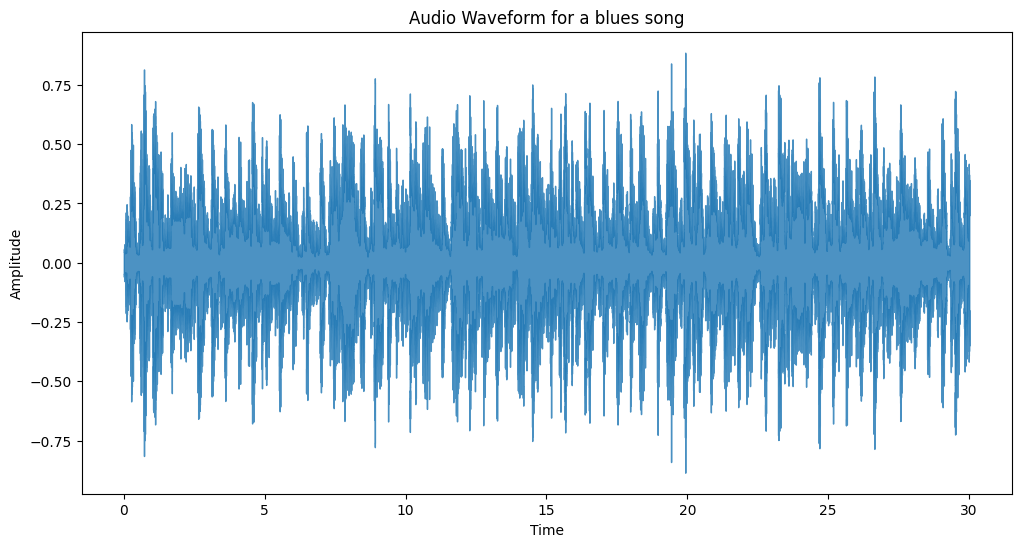

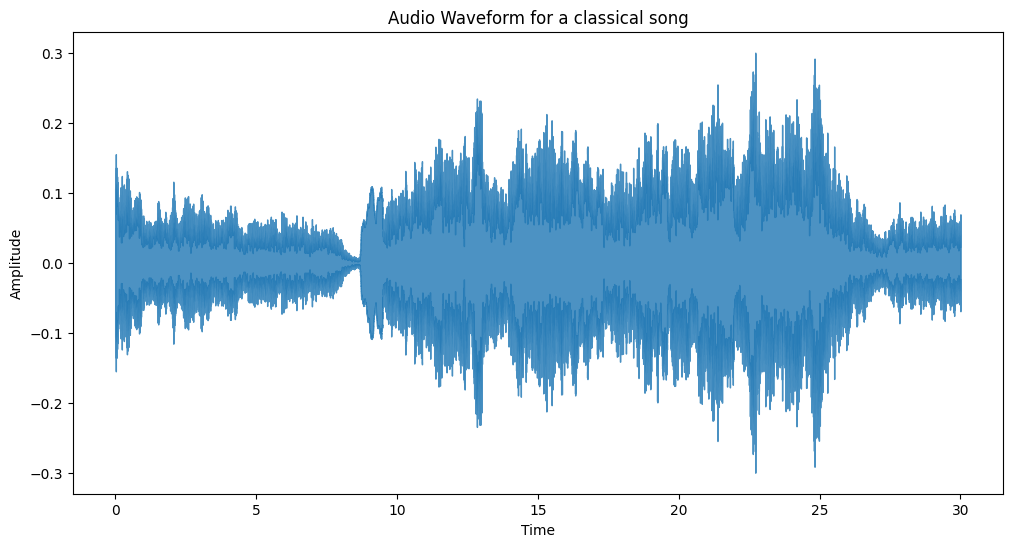

In [23]:
plot_waveform(audio_ex, fs);
plt.title('Audio Waveform for a blues song');
plot_waveform (audio_ex2, fs);
plt.title('Audio Waveform for a classical song');

In [24]:
def calc_spectrum(audio, kind='mag'):
    spec = scipy.fft.fft(x=audio) ##fast fourier transform
    
    if kind.lower() == 'm' or 'mag' or 'magnitude':
        spec_db = 20*np.log10(np.abs(spec))
    elif kind.lower() == 'p' or 'pha' or 'phase':
        spec_db = 20*np.log10(np.imag(spec))
    elif kind.lower() == 'c' or 'com' or 'complex':
        spec_db = 20*np.log10(spec)
        
    return spec_db
    

In [25]:
def plot_spectrum(audio, samplingFrequency, kind='mag'):
    spec_db = calc_spectrum(audio, kind=kind) #spectrum in db unit
    f_axis = np.linspace(0, samplingFrequency, len(spec_db)) 
    #frequencies below nyquist rate (Fns = (1/2)fs)
    f_axis = f_axis[:int(len(spec_db)/2)]
    spec_db = spec_db[:int(len(spec_db)/2)]
    ax = plt.figure(figsize = (12, 6))
    plt.plot(f_axis, spec_db, alpha=1.0)
    plt.xscale('log')
    plt.xlim(1, samplingFrequency/2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    if fs < 44100:
        plt.xticks([1, 2, 4, 8, 16, 31, 63, 125, 250,500,1000,2000,5000,10000], 
                   ["1", "2", "4", "8", "16", "31", "63", "125", "250", "500", "1K", "2K", "5K", "10K"])
    else:
        plt.xticks([1, 2, 4, 8, 16, 31, 63, 125, 250,500,1000,2000,5000,10000, 20000], 
                   ["1", "2", "4", "8", "16", "31", "63", "125", "250", "500", "1K", "2K", "5K", "10K", "20k"])

Text(0.5, 1.0, 'Audio spectrum for a classical song')

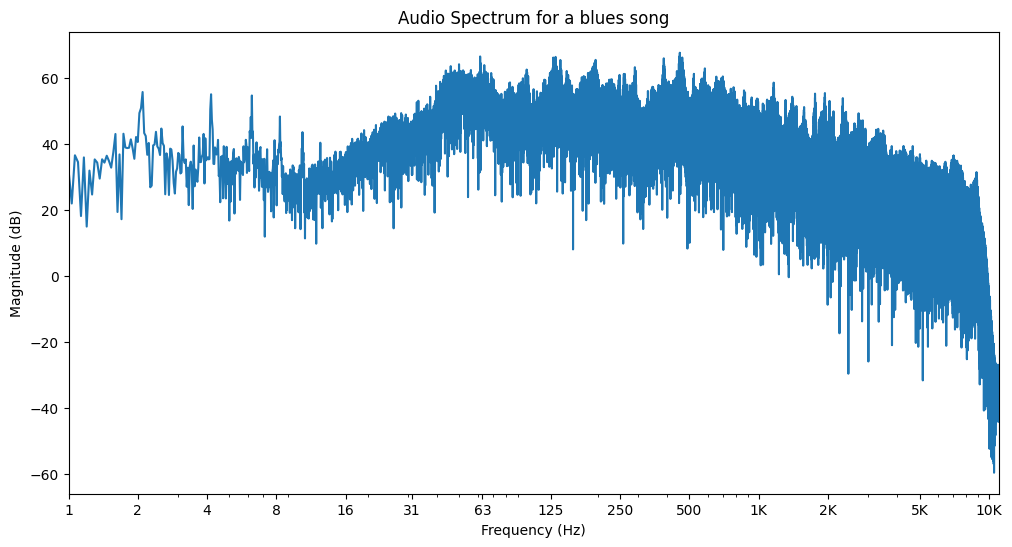

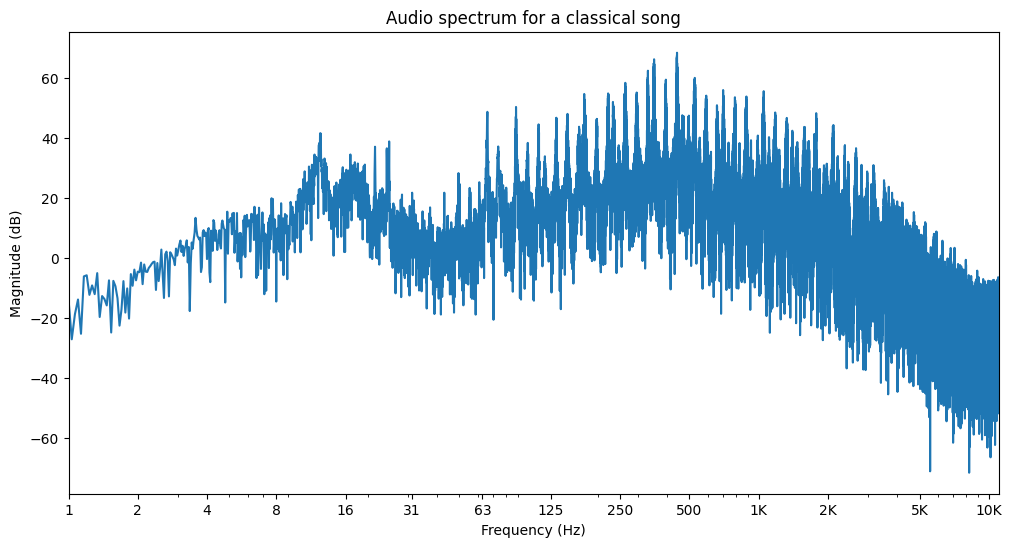

In [26]:
plot_spectrum(audio_ex, fs)
plt.title('Audio Spectrum for a blues song')

plot_spectrum(audio_ex2, fs)
plt.title('Audio spectrum for a classical song')

In [27]:
def calc_stft(audio, fs, n_fft=2048, hop_length=512, dB=True): #short time fourier transform
   
    stft = np.abs(librosa.stft(y=audio, n_fft=n_fft, hop_length=hop_length))
    
    if dB:
        stft = librosa.amplitude_to_db(stft, ref=np.max)

    return stft

In [28]:
def plot_spectrogram(audio, fs, n_fft=2048, hop_length=512, dB=True, fig_size=(12,6)):
   
    stft_db = calc_stft(audio, fs, n_fft=n_fft, hop_length=hop_length, dB=dB)
    
    plt.figure(figsize=fig_size)
    librosa.display.specshow(data=stft_db, sr=fs, x_axis='time', y_axis='log', cmap='viridis')

    plt.title('Spectrogram')

    plt.colorbar(format='%+02.0f dB')

    plt.tight_layout();

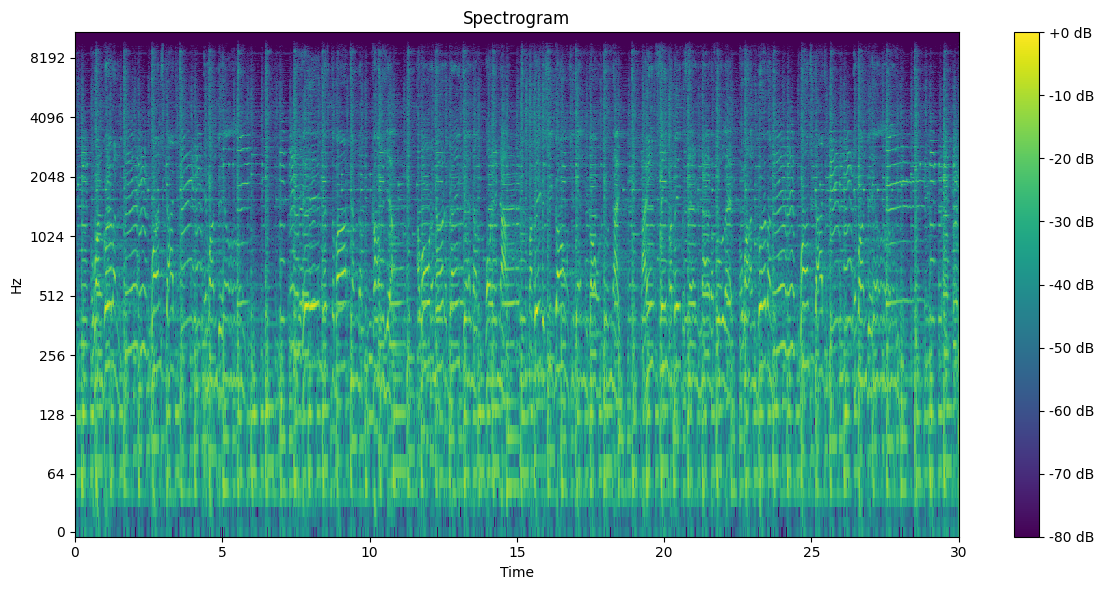

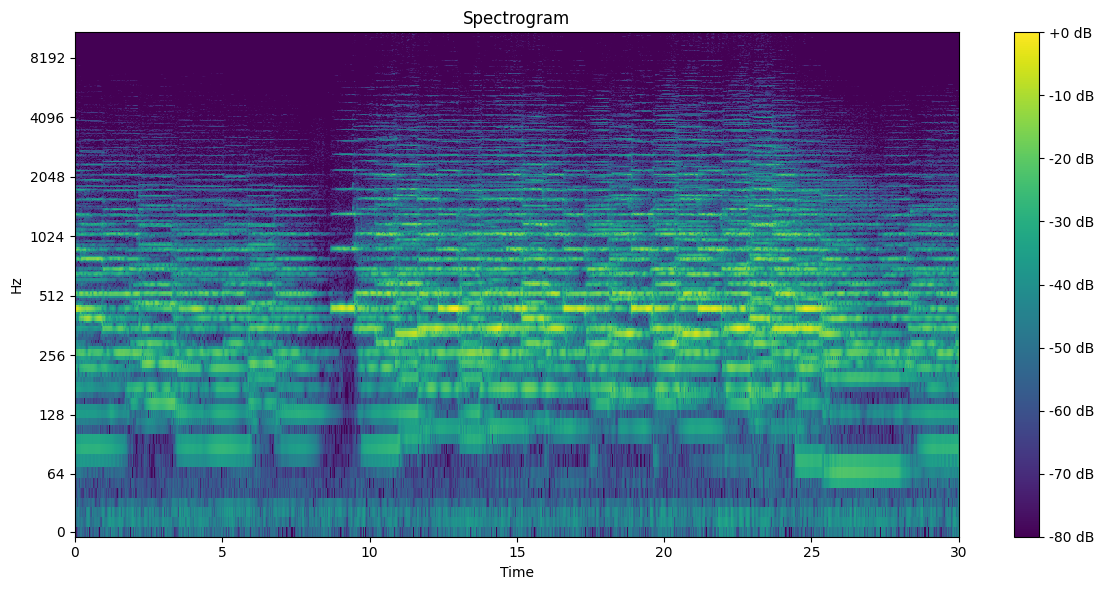

In [29]:
n_fft = 2048
hop_length = 512
dB = True 
plot_spectrogram(audio_ex, fs, n_fft=n_fft, dB=dB, hop_length=hop_length)
plot_spectrogram(audio_ex2, fs, n_fft=n_fft, dB=dB, hop_length=hop_length)

In [30]:
def get_mfccs(directory_path, fs=22500, duration=30, n_fft=2048, hop_length=512, n_mfcc=13, num_segments=10):
   
    data = {
        "genre_name": [],   
        "genre_num": [],    
        "mfcc": []          
    }
     
    samples_per_track = fs * duration 
    samps_per_segment = int(samples_per_track/num_segments)
    mfccs_per_segment = math.ceil(samps_per_segment/hop_length)

    print("MFCC collection started!")
    print("========================")
    for i, (path_current, folder_names, file_names) in enumerate(os.walk(directory_path)):
        
      
        if path_current is not directory_path:
        
            # Save 
            path_list = path_current.split('/')
            genre_current = path_list[-1]
            
            for file in file_names:
                
                file_path = os.path.join(path_current, file).replace(os.sep, '/')

                try:
                    audio, fs = librosa.load(file_path, sr=fs) 

                    # Loop through audio file for specified number of segments to calculate MFCCs
                    for seg in range(num_segments):

                        start_sample = seg * samps_per_segment
                        end_sample = start_sample + samps_per_segment 

                        mfcc = librosa.feature.mfcc(y=audio[start_sample:end_sample],    
                                                    sr=fs,                              
                                                    n_fft=n_fft,                       
                                                    hop_length=hop_length,               
                                                    n_mfcc=n_mfcc)                      

                        mfcc = mfcc.T

                        
                        if len(mfcc) == mfccs_per_segment:
                            data["genre_name"].append(genre_current) 
                            data["genre_num"].append(i-1) 
                            data["mfcc"].append(mfcc.tolist())
                except:
                    continue

            print(f"Collected MFCCs for {genre_current.title()}!")
    
    with open('./data/data.json', "w") as filepath:
        print("========================")
        print("Saving data to disk...")
        json.dump(data, filepath, indent=4)
        print("Saving complete!")
        print("========================")
    
    return np.array(data["mfcc"]), np.array(data["genre_name"]), np.array(data["genre_num"])


In [31]:

n_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 10 # split teack into 10 segments (3 sec each)
track_duration = 30 # Length of tracks (sec)

directory_path = './data/genres_original/'
mfccs, genres, genre_nums = get_mfccs(directory_path,
                          fs=fs,
                          duration=track_duration,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          n_mfcc=n_mfcc, 
                          num_segments=num_segments)

MFCC collection started!
Collected MFCCs for Blues!
Collected MFCCs for Classical!
Collected MFCCs for Country!
Collected MFCCs for Disco!
Collected MFCCs for Hiphop!


C:\Users\Asus\AppData\Local\Temp\ipykernel_17588\2556767103.py:29: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(file_path, sr=fs)
c:\Users\Asus\Minor2\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Collected MFCCs for Jazz!
Collected MFCCs for Metal!
Collected MFCCs for Pop!
Collected MFCCs for Reggae!
Collected MFCCs for Rock!
Saving data to disk...
Saving complete!


In [32]:
print(f"MFCCs: {mfccs.shape}")
print(f"genres: {genres.shape}")

MFCCs: (9981, 130, 13)
genres: (9981,)


In [33]:
print(mfccs)

[[[-2.42435989e+02  1.02184868e+02 -9.91323471e+00 ... -3.95323277e+00
   -2.40564632e+00 -2.38090801e+00]
  [-2.12989746e+02  1.03544785e+02 -1.08341713e+01 ... -5.81353378e+00
    2.64356709e+00 -2.80662346e+00]
  [-1.95409302e+02  1.04360657e+02 -1.85502887e-01 ... -1.08171625e+01
   -5.88805974e-01 -5.28410244e+00]
  ...
  [-1.24157700e+02  6.37352219e+01  2.11729393e+01 ... -1.65676632e+01
    1.37965145e+01 -2.31835346e+01]
  [-1.11283936e+02  6.05447235e+01  1.33710217e+00 ... -1.22842150e+01
    1.48256063e+01 -1.58052387e+01]
  [-1.31811951e+02  6.65644531e+01 -7.93185902e+00 ... -8.66252232e+00
    1.16732750e+01 -8.72385406e+00]]

 [[-1.71760757e+02  8.67187042e+01 -1.29779530e+01 ... -7.98365927e+00
    3.68273306e+00 -4.20823669e+00]
  [-1.53283447e+02  9.38014526e+01 -2.03874588e+01 ... -7.75853205e+00
    8.76973343e+00 -9.67060471e+00]
  [-1.64260010e+02  9.80545425e+01 -2.59105625e+01 ... -6.87140560e+00
    1.37144995e+01 -7.40781355e+00]
  ...
  [-1.92144089e+02  1.1

In [34]:
genre_map = dict(zip(sorted(set(genres)), np.arange(0, 10)))
genres_num = np.array(pd.Series(genres).map(genre_map))

In [ ]:
def plot_mfcc(mfcc, fs, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.
    
    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)
    
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    
    plt.title('MFCCs')

    plt.colorbar(format='%+02.0f dB')

    plt.tight_layout()


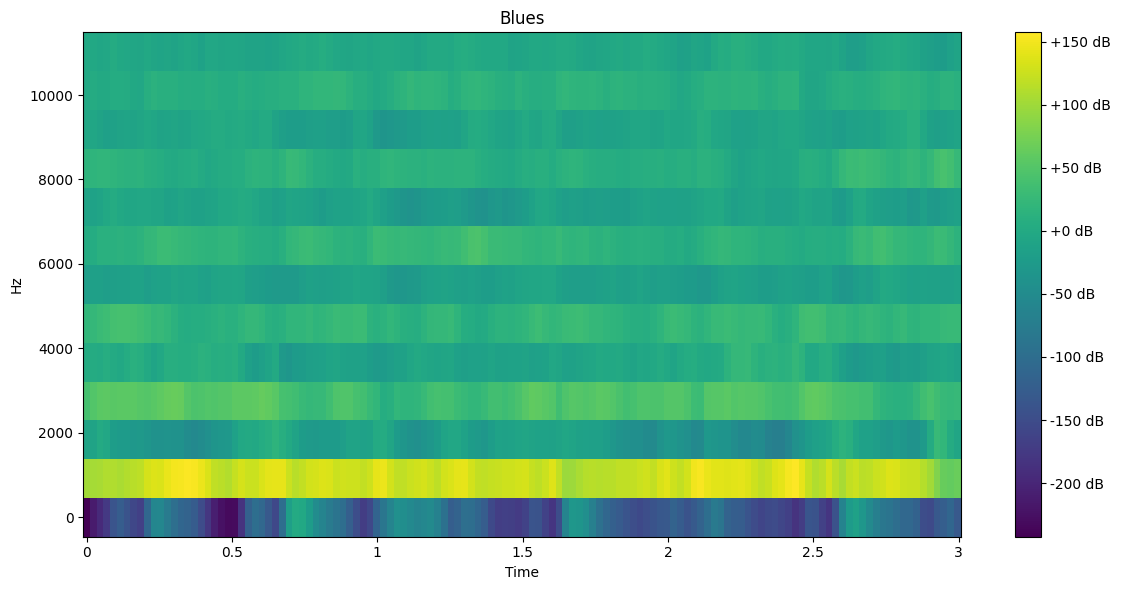

In [36]:
idx = 0
plot_mfcc(mfccs[idx].T, fs)
plt.title(f"{genres[idx].title()}");